### Clustering Tinder Profiles
In this notebook I will import multiple csv files of tinder profile data scraped from users in my area using a python API/package.

In [1]:
# import dependencies
%matplotlib inline
import csv as csv
import numpy as np
import pandas as pd
import pylab as py
import operator
import re, os, progressbar
import sys
import nltk
from pprint import *
from sklearn.manifold import TSNE
import multiprocessing
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as skmetrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.externals import joblib
from operator import itemgetter
import pickle
import logging
from sklearn.decomposition import NMF, LatentDirichletAllocation
from time import time
import codecs
import gensim.models.word2vec as w2v
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("dutch")

from __future__ import print_function

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Import the Data

In [2]:
filepath  = '/Users/HAL3000/Dropbox/coding/Insight/Tinder/data/results.csv'
print('Importing data:',filepath)
test_data = pd.read_csv(filepath)
#test_data.reset_index(drop=True,inplace=True)
test_data.head(10)

Importing data: /Users/HAL3000/Dropbox/coding/Insight/Tinder/data/results.csv


,name,gender,birth_year,bio,distance_mi,photos,schools,jobs,instagram,spotify
0,Katie,F,1987,My name is Katie im looking for a serious rela...,19,http://images.gotinder.com/5a433e5236e65f961d5...,NaN,ISC @ undefined,NaN,NaN
1,Michelle,F,1974,NaN,41,http://images.gotinder.com/5a57e925347976ac2d3...,"Walden University, Walden University",Care giver for disabled @ Personal Home Caregiver,NaN,NaN
2,Alissa,F,1981,Whiskey lover. Vegetarian. Tattooed gal. Looki...,1,http://images.gotinder.com/5a348af8c42152b3167...,NaN,AR Ops Manager @ undefined,NaN,NaN
3,Jessica,F,1984,Ask and find out. The answers might surprise you.,73,http://images.gotinder.com/53eafffe4f7f8e9c4ca...,University of Alberta,NaN,NaN,NaN
4,Susan,F,1981,"Seattle-based curator of design, architecture ...",4,http://images.gotinder.com/55cfaa97a0d073de3a3...,"Yale School of Architecture, Parsons School of...",Curator @ undefined,NaN,"I'm Your Man, Leonard Cohen, I'm Your Man"
5,Yolanda,F,1969,Just looking to date. I'm ready for some Snow...,18,http://images.gotinder.com/5918b81c6fe3c7856e2...,William Rainey Harper College,undefined @ Private company,NaN,NaN
6,Christy,F,1976,"I am a laid-back, fun-loving, well-traveled, w...",6,http://images.gotinder.com/597aafeaaa3a5a7e7fb...,NaN,RN @ undefined,NaN,NaN
7,Zuri,F,1988,NaN,7,http://images.gotinder.com/5a2e13772f46971c105...,Eastern Washington University,NaN,NaN,NaN
8,Rex,F,1990,I think about birds the most. My siblings are ...,4,http://images.gotinder.com/5a558df1cb58ec106ae...,NaN,NaN,NaN,"The Front Door, Valerie June, The Order Of Time"
9,Tyesha,F,1989,NaN,7,http://images.gotinder.com/5a56ef1f69c73afa6ff...,NaN,Leasing Manager @ undefined,NaN,NaN


In [3]:
# What are the dimensions(how many tinder profiles and features)?
test_data.shape

(10033, 10)

### We now need to encode the text features
tips: http://pbpython.com/categorical-encoding.html

In [4]:
# What types of data do we have?
test_data.dtypes

name           object
gender         object
birth_year      int64
bio            object
distance_mi     int64
photos         object
schools        object
jobs           object
instagram      object
spotify        object
dtype: object

In [5]:
# Let's only keep the features which are of interest to us
test_data = test_data.drop(['name', 'photos', 'instagram'], axis=1)

In [6]:
# Now we can pandas category function to encode some of the text(gender first)
#test_data["gender"] = test_data["gender"].astype('category')
test_data["gender"] = test_data["gender"].astype('category').cat.codes
test_data.dtypes

gender           int8
birth_year      int64
bio            object
distance_mi     int64
schools        object
jobs           object
spotify        object
dtype: object

In [7]:
test_data.head(5)

,gender,birth_year,bio,distance_mi,schools,jobs,spotify
0,0,1987,My name is Katie im looking for a serious rela...,19,NaN,ISC @ undefined,NaN
1,0,1974,NaN,41,"Walden University, Walden University",Care giver for disabled @ Personal Home Caregiver,NaN
2,0,1981,Whiskey lover. Vegetarian. Tattooed gal. Looki...,1,NaN,AR Ops Manager @ undefined,NaN
3,0,1984,Ask and find out. The answers might surprise you.,73,University of Alberta,NaN,NaN
4,0,1981,"Seattle-based curator of design, architecture ...",4,"Yale School of Architecture, Parsons School of...",Curator @ undefined,"I'm Your Man, Leonard Cohen, I'm Your Man"


In [8]:
# Get rid of all NAs
test_data = test_data.fillna('')
test_data.head(5)

,gender,birth_year,bio,distance_mi,schools,jobs,spotify
0,0,1987,My name is Katie im looking for a serious rela...,19,,ISC @ undefined,
1,0,1974,,41,"Walden University, Walden University",Care giver for disabled @ Personal Home Caregiver,
2,0,1981,Whiskey lover. Vegetarian. Tattooed gal. Looki...,1,,AR Ops Manager @ undefined,
3,0,1984,Ask and find out. The answers might surprise you.,73,University of Alberta,,
4,0,1981,"Seattle-based curator of design, architecture ...",4,"Yale School of Architecture, Parsons School of...",Curator @ undefined,"I'm Your Man, Leonard Cohen, I'm Your Man"


In [9]:
# I would also like to get rid of undefined and @. 
# Next add a list of words to remove
#test_data.head(5)

In [10]:
# Smash together all text into a new feature column
test_data["all_text"] = test_data["bio"] + ' ' + test_data["schools"] + ' ' + test_data["jobs"] + ' ' +  test_data["spotify"]
test_data['all_text'] = test_data['all_text'].str.replace('\d+', '')

test_data['all_text'] = test_data['all_text'].replace({'undefined': ''}, regex=True)
test_data['all_text'] = test_data['all_text'].replace({'@': ''}, regex=True)
test_data['all_text'] = test_data['all_text'].replace({'college': 'university'}, regex=True)
test_data['all_text'] = test_data['all_text'].replace({'Seattle': ''}, regex=True)
test_data['all_text'] = test_data['all_text'].replace({'Washington': ''}, regex=True)

# Stemming
#test_data['all_text'] = test_data["all_text"].apply(lambda x: stemmer.stem(y) for y in x)

# split a small test set off
msk = np.random.rand(len(test_data)) < 0.9998999

train = test_data[msk]
test = test_data[~msk]

print('# of Train Profiles:',len(train))
print('# of Test Profiles:',len(test))


# of Train Profiles: 10033
# of Test Profiles: 0


In [11]:
train.head(5)

,gender,birth_year,bio,distance_mi,schools,jobs,spotify,all_text
0,0,1987,My name is Katie im looking for a serious rela...,19,,ISC @ undefined,,My name is Katie im looking for a serious rela...
1,0,1974,,41,"Walden University, Walden University",Care giver for disabled @ Personal Home Caregiver,,"Walden University, Walden University Care giv..."
2,0,1981,Whiskey lover. Vegetarian. Tattooed gal. Looki...,1,,AR Ops Manager @ undefined,,Whiskey lover. Vegetarian. Tattooed gal. Looki...
3,0,1984,Ask and find out. The answers might surprise you.,73,University of Alberta,,,Ask and find out. The answers might surprise y...
4,0,1981,"Seattle-based curator of design, architecture ...",4,"Yale School of Architecture, Parsons School of...",Curator @ undefined,"I'm Your Man, Leonard Cohen, I'm Your Man","-based curator of design, architecture and art..."


## Embedding the Words
Now that we have a single feature column with all text appeneded we can create our unique word dictionary and embeddings.

In [12]:
count_vect = CountVectorizer(stop_words="english")#, max_features = 25)
#cv_alltext      = count_vect.fit_transform(test_data['all_text'].values.astype('U'))
cv_alltext = count_vect.fit_transform(train['all_text'].values.astype('U'))
#count_vect.vocabulary_.get(u'algorithm')
vocab = count_vect.vocabulary_
feature_list = [word for word in vocab.keys()] 
features = count_vect.get_feature_names()
#print(features)

In [13]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.
    '''

    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'CV']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' 
    Top tfidf features in specific document (matrix row) 
    '''
    
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. 
        Xtr = tfidf array
        features = names from vocab(list)
    '''
    
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_sum_feats(Xtr, features, grp_ids=None, top_n=25):
    ''' Return the top n features that are the most frequent amongst documents in rows
        indentified by indices in grp_ids. 
        Xtr = tfidf array
        features = names from vocab(list)
    '''
    
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    tfidf_sums = np.sum(D, axis=0)
    return top_tfidf_feats(tfidf_sums, features, top_n)

print(top_mean_feats(cv_alltext, features))
top_mean_features = top_mean_feats(cv_alltext, features)
print('\n\n')
#print(top_sum_feats(cv_alltext, features))

       feature        CV
0   university  0.367188
1         love  0.355826
2      looking  0.309678
3         like  0.228645
4         just  0.162464
5      college  0.161667
6          new  0.156783
7          don  0.144922
8         good  0.137446
9         life  0.128376
10        time  0.118808
11         fun  0.112429
12      people  0.111632
13     friends  0.105153
14       music  0.103857
15      things  0.102661
16        work  0.088508
17       enjoy  0.088309
18        want  0.086215
19        know  0.083923
20        live  0.071265
21        kids  0.070467
22      travel  0.069770
23       state  0.069670
24        meet  0.068374





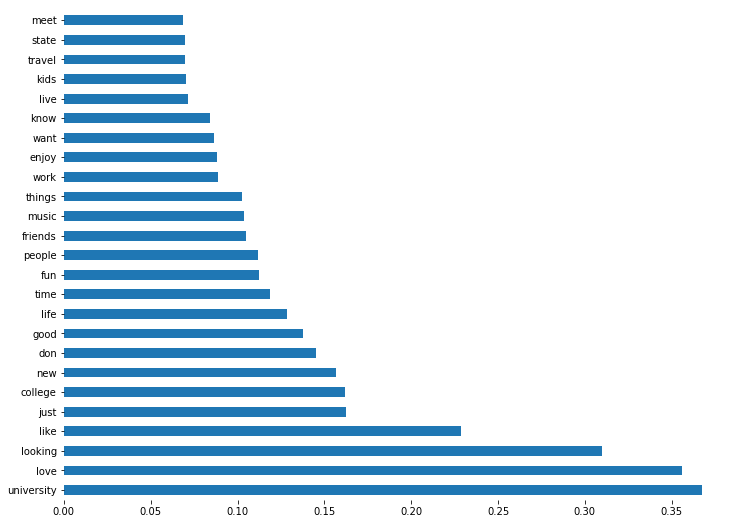

In [14]:
def plot_feats_h(df):
    ''' Plot the data frames returned by the function top_mean_feats(). 
    '''
    #print(dfs)
    
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    #ax = fig.add_subplot(1, 1, 1)   
    #ax.spines["top"].set_visible(False)
    #ax.spines["right"].set_visible(False)
    #ax.set_frame_on(False)
    #ax.get_xaxis().tick_bottom()
    #ax.get_yaxis().tick_left()
    #ax.set_xlabel("Mean Score", labelpad=16, fontsize=14)
    #ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
    ax = df['CV'].plot(kind='barh') 
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
        
    ticks = ax.set_yticklabels(df.feature)
    #plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.savefig('word_freq.png')
    plt.show()
    
plot_feats_h(top_mean_features)

In [15]:
# Now look by Gender
targets = test_data['gender'].values

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label.
        Xtr = tfidf array
        features = names from vocab(list)
        y = class labels(fake or real)
    '''
    
    dfs = []
    labels = np.unique(y)
    #print(labels)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        
        if label == 0:
            feats_df.label = 'Female'
        else: feats_df.label = 'Male'
             
        
        dfs.append(feats_df)
    return dfs

#df_class_list = top_feats_by_class(cv_alltext, targets, features)

def plot_tfidf_classfeats_h(dfs, title):
    ''' Plot the data frames returned by the function top_feats_by_class(). 
    '''
    
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.CV, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.savefig('word_freq_compare.png')
    plt.show()
    
#plot_tfidf_classfeats_h(df_class_list, 'TFIDF')

## A quick look at word2vec
Up to this point we had considered our data in word "chunks", that is we broke each sentence into individual parts. In doing so we may have lost a bit of descriptive due to ignoring the holistic nature of words within the document from which it came. Now we will look at words in the context of the sentences in which they reside. To do so we will use the NLTK package for cleaning and tokenization by sentence. Once sentences have been tokenized we will use Word2vec to cluster words together and to find patterns within sentences and documents. Developed at Google, Word2Vec is an unsupervised 2-layer neural network that uses backpropagation to assign probabilites for each word to occur near another for in a given interval.

The relevant output of the shallow NN is the weight matrix of the hidden layer. This matrix works essentially as a look-up table for any word given as input. The output for any word input will be a word vector corresponding to that word and whose entries are probabilities to be found near other words. Through this method we can cluster words together by looking for similarities between the word vectors(the output of word2vec) and not the input word frequencies.

The hyperparameters of the NN are:

num_features is the number of dimensions we want to embed our words in (the length of the final word vectors)
min_word_count, if the count of a words use is below this threshold, corpus wide, ignore the word
context_size is the window size left and right of the target word to consider words

In [16]:
def sent_token(text):
    text = nltk.sent_tokenize(text)
    return text

def sentence_clean(text):
    new_text = []
    for sentence in text:
        sentence = sentence.lower()
        sentence = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", sentence)
        sentence = re.sub("[^a-z ]", "", sentence)
        sentence = nltk.word_tokenize(sentence)
        sentence = [word for word in sentence if len(word)>1] # exclude 1 letter words
        new_text.append(sentence)
    return new_text

def apply_all(text):
    return sentence_clean(sent_token(text))

In [17]:
# Tokenize the sentences
test_data['sent_tokenized_text'] = test_data['all_text'].apply(apply_all)
all_sentences = list(test_data['sent_tokenized_text'])
all_sentences = [subitem for item in all_sentences for subitem in item]

In [18]:
# Word2Vec Hyperparameters
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3

all2vec = w2v.Word2Vec(
    sg=1,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [19]:
# Train w2v
if not os.path.exists('w2v_matrix.p'):
    all2vec.build_vocab(all_sentences)
    print("Word2Vec vocabulary length:", len(all2vec.wv.vocab))
    print('\nTraining Word2Vec...')
    all2vec.train(all_sentences, total_examples=all2vec.corpus_count, epochs=all2vec.iter)
    all_word_vectors_matrix = all2vec.wv.syn0
    vocab = all2vec.wv.vocab
    pickle.dump(all_word_vectors_matrix, open('w2v_matrix.p', 'wb')) 
    pickle.dump(vocab, open('w2v_vocab.p', 'wb')) 
else:    
    all_word_vectors_matrix = pickle.load(open('w2v_matrix.p', 'rb'))
    vocab = pickle.load(open('w2v_vocab.p', 'rb'))
    print('\nLoaded Word2Vec Results...')

# Output shape
all_word_vectors_matrix.shape    


Loaded Word2Vec Results...


(3362, 300)

## Visualizing Word2Vec output
A common technique to visualize our newly clustered words is to use TSNE(https://lvdmaaten.github.io/tsne/). TSNE utilizes dimensionality reduction in order to visualize our embedded word relationships in a 2-D representation. Each cluster in this plot can be thought of as a new feature that could be used for training in another algroithm. Instead of hundreds of thousands of unique word features, word2Vec has provided us with a reduced feature set. Whether or not this reduced feature set will provide better seperation power versus real news features will be one of the questions I will look at as this project continues.

In [20]:
if not os.path.exists('tsne_fit.p'):
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y_all = tsne.fit_transform(all_word_vectors_matrix)
    pickle.dump(Y_all, open('tsne_fit.p', 'wb')) 
else:
    Y_all = pickle.load(open('tsne_fit.p', 'rb'))
    print('\nLoaded TSNE Fit Results')    


Loaded TSNE Fit Results


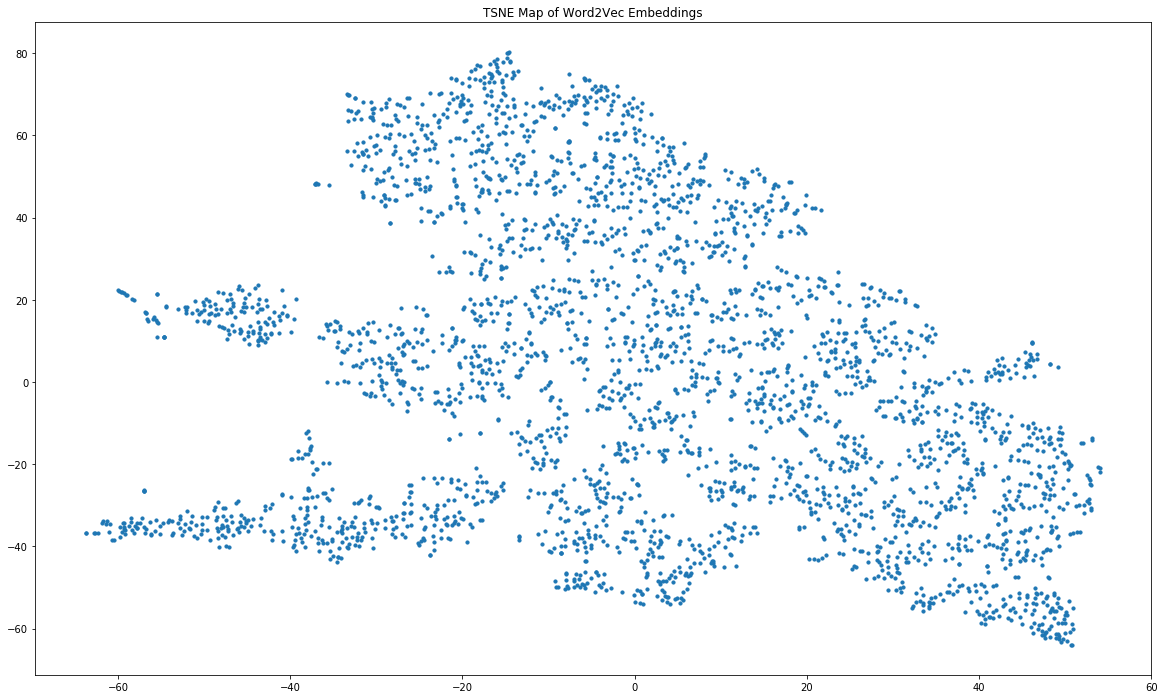

In [21]:
# Plot all words
plt.figure(figsize=(20,12))
plt.scatter(Y_all[:, 0], Y_all[:, 1],s=10)

#for label, x, y in zip(df_CV_FP_25['feature'], Y_FP[:, 0], Y_FP[:, 1]):
#    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

plt.title("TSNE Map of Word2Vec Embeddings")
plt.savefig('all_w2v_tsne.png')
plt.show()

# Finding my first LDA personality clusters
See sci-kit blog post here: http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [22]:
# My dataset is defined below
lda_data   = test_data
n_samples  = lda_data.shape[0]
n_features = lda_data.shape[1] 

# define the number of clusters to create
n_components = 5

print("Fitting LDA models with CV word features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

Fitting LDA models with CV word features, n_samples=10033 and n_features=9...


In [23]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Personality #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

t0 = time()
lda.fit(cv_alltext)
print("done in %0.3fs." % (time() - t0))

print("\nPersonalities in LDA model:")
feature_names = count_vect.get_feature_names()
print_top_words(lda, feature_names, 10)

done in 27.010s.

Personalities in LDA model:
Personality #0: university college school state teacher pacific owner law lover remastered
Personality #1: college community th pic technical agent park feat gucci clover
Personality #2: looking like love don just university good time things college
Personality #3: feat valley florida line skagit georgia institute stylist original soundtrack
Personality #4: love university looking new like life just people meet friends



 ## Testing a new Profile
Now I would like test a single profile into the trained LDA weights and see what label it is assigned to.  I would also like to see the shape of the LDA output weights.

In [24]:
print(test['all_text'])
X_test = count_vect.transform(test['all_text'])
print(X_test.shape)
X_test_lda = lda.transform(X_test)
print('Output Prediction LDA Vectors:', X_test_lda) 
print('Shape of LDA Vectors:', X_test_lda.shape)

Series([], Name: all_text, dtype: object)
(0, 18714)


ValueError: Found array with 0 sample(s) (shape=(0, 18714)) while a minimum of 1 is required.

In [ ]:
# normalized doc-topic distribution
doc_topic_dist = np.matrix(lda.transform(X_test))

print('Predicted Tinder Personality #:',doc_topic_dist.argmax(axis=1))
